In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import librosa.display
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras 

In [29]:
print(f"current dir: {os.getcwd()}")

current dir: /Users/kehwaweng/Documents/speech_denoise/noise_reduction


In [30]:
# model = keras.models.load_model("./experiment/20210315-124505/NoiseSuppressionModel.h5")
model = keras.models.load_model("./experiment/20210324-133017/NoiseSuppressionModel.h5")
# model = keras.models.load_model("/Users/kehwaweng/Documents/speech_denoise/speech_denoise/output_temp/20210324-115625/models/epoch-013-loss-0.016549.h5")
# model.summary()

In [47]:
# clean_sounds = glob.glob('/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/facebookresearch/train/clean_trainset_wav/*')
# noisy_sounds = glob.glob('/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/facebookresearch/train/noisy_trainset_wav/*')

clean_sounds = glob.glob('/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/facebookresearch/valid/clean_testset_wav/*')
noisy_sounds = glob.glob('/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/facebookresearch/valid/noisy_testset_wav/*')

In [129]:
# batching_size = 12000
batch_ing_size = 4800

In [130]:
def get_audio(path):
    audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
    return audio

In [148]:
def inference_preprocess(path):
    audio = get_audio(path)
    audio_len = audio.shape[0]
    batches = []
    for i in range(0,audio_len-batching_size,batching_size):
        batches.append(audio[i:i+batching_size])

    batches.append(audio[-batching_size:])
    diff = audio_len - (i + batching_size)
    return tf.stack(batches), diff

# def inference_preprocess(arr):
# #     audio = get_audio(path)
# #     audio_len = audio.shape[0]
#     audio_len = arr.shape[0]
#     batches = []
#     for i in range(0,audio_len-batching_size,batching_size):
#         batches.append(arr[i:i+batching_size])

#     batches.append(arr[-batching_size:])
#     diff = audio_len - (i + batching_size)
#     return tf.stack(batches), diff

In [149]:
def predict(path):
    test_data, diff = inference_preprocess(path)
    predictions = model.predict(test_data)
    final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1) * predictions.shape[1],1))
    final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
    return final_op

In [150]:
selected_index = np.random.choice(range(len(noisy_sounds)))
print(f"selected index : {selected_index}")

selected index : 530


In [151]:
# ipd.Audio(np.squeeze(get_audio(noisy_sounds[selected_index]).numpy(),-1), rate = 16000)
ipd.Audio(np.squeeze(get_audio(noisy_sounds[selected_index]).numpy(),-1), rate = 48000)
# ipd.Audio(np.squeeze(get_audio(noise_sound).numpy(),-1), rate = 48000)

In [154]:
# ipd.Audio(tf.squeeze(predict(noisy_sounds[selected_index])), rate= 16000)

wave = predict(noisy_sounds[selected_index]) 
ipd.Audio(tf.squeeze(wave), rate= 48000)
# ipd.Audio(tf.squeeze(predict(noise_sound)), rate= 48000)

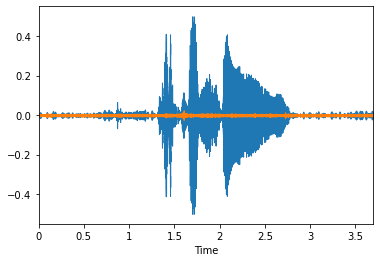

In [156]:
librosa.display.waveplot(np.squeeze(get_audio(clean_sounds[selected_index]).numpy(),-1))
# librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[selected_index]).numpy(),-1))

librosa.display.waveplot(np.squeeze(predict(noisy_sounds[selected_index])))

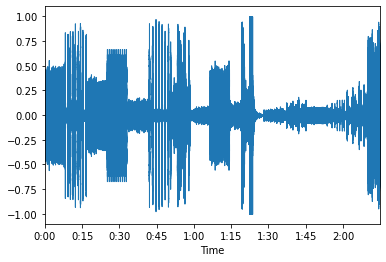

In [15]:
path = "/Users/kehwaweng/Desktop/noisy_speech.wav"
librosa.display.waveplot(np.squeeze(get_audio(path).numpy(),-1))
ipd.Audio(np.squeeze(get_audio(path).numpy(),-1), rate = 16000)

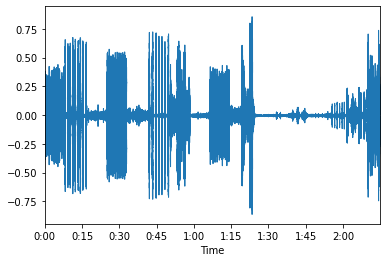

In [53]:
pred= predict(path)
ipd.Audio(np.squeeze(pred.numpy(),-1), rate= 16000)
librosa.display.waveplot(np.squeeze(pred))

In [65]:
# clean_sounds = glob.glob("/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/LibriSpeech/dev-other/116/288045/*")
clean_sounds = glob.glob("/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/LibriSpeech/dev-clean/8842/304647/*.wav")


In [67]:
from tqdm import tqdm
clean_sounds_list, _ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]), desired_channels = 1)
for i in tqdm(clean_sounds[1:]):
    so, _ = tf.audio.decode_wav(tf.io.read_file(i), desired_channels = 1)
    clean_sounds_list = tf.concat((clean_sounds_list,so), 0)

100%|██████████| 13/13 [00:00<00:00, 43.26it/s]


In [90]:
print(f"clean sound list : {clean_sounds_list.shape}")
batching_size = 12000

urban_sound_list = glob.glob("/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/UrbanSound8K/audio/fold*/*")
concat_len = clean_sounds_list.shape[0]
noise_concat = np.array([0]).reshape((1,1))
while noise_concat.shape[0]  < concat_len + 1:
    try:
        file = np.random.choice(urban_sound_list)
        wave, _ = tf.audio.decode_wav(tf.io.read_file(file), desired_channels = 1)
        noise_concat = np.concatenate((noise_concat, wave))
    except:
        pass
noise_concat = noise_concat[1: 1 + concat_len]

clean sound list : (2744720, 1)


In [91]:
noise_concat.shape

(2744720, 1)

In [165]:
concat = np.array([0])
for i in range(5,15):
    tag = f"{i}".zfill(3)

    path = f"/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/facebookresearch/valid/noisy_testset_wav/p232_{tag}.wav"
    try:
        wave, sr = librosa.load(path, sr=None)        
        concat = np.concatenate((concat,wave))
    except:
        pass
concat = concat[1:]
ipd.Audio(concat, rate = 48000)

import soundfile as sf
sf.write(file = "/Users/kehwaweng/Desktop/noisy_speech_0409.wav", data=concat, samplerate = 48000)